In [6]:

from matplotlib import pyplot as plt
import time
import cv2

def stitch(path1, path2):
    """
    传入图片路径，返回变换过后的填充图片
    Args:
        path1(str): 图像
        path1 (str): 拼接图像

    Returns:
        res (ndarray): 拼接后的图像.
    """
    top, bot, left, right = 100, 100, 0, 800
    img1 = cv2.imread(path1)
    img2 = cv2.imread(path2)
    img1_size = img1.shape[:2]
    img2 = cv2.resize(img2, (img1_size[1], img1_size[0])) # 将第二张图像调整到与第一张图像相同的大小。

    srcImg = cv2.copyMakeBorder(img1, top, bot, left, right, cv2.BORDER_CONSTANT, value=(0, 0, 0))
    testImg = cv2.copyMakeBorder(img2, top, bot, left, right, cv2.BORDER_CONSTANT, value=(0, 0, 0))
    img1gray = cv2.cvtColor(srcImg, cv2.COLOR_BGR2GRAY)
    img2gray = cv2.cvtColor(testImg, cv2.COLOR_BGR2GRAY) # 将两张图像分别进行灰度转换和边界填充。
    sift = cv2.SIFT_create()
    # 通过SIFT算法检测两个图像中的关键点和描述符
    kp1, des1 = sift.detectAndCompute(img1gray, None)
    kp2, des2 = sift.detectAndCompute(img2gray, None)

    # FLANN 算法参数
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    # 使用 FLANN 算法匹配两幅图像之间的描述符。
    matchesMask = [[0, 0] for i in range(len(matches))]
    good = []
    pts1 = []
    pts2 = []
    # 执行比率测试以过滤出错误匹配。
    for i, (m, n) in enumerate(matches):
        if m.distance < 0.7 * n.distance:
            good.append(m)
            pts2.append(kp2[m.trainIdx].pt)
            pts1.append(kp1[m.queryIdx].pt)
            matchesMask[i] = [1, 0]

    draw_params = dict(matchColor=(0, 255, 0),
                       singlePointColor=(255, 0, 0),
                       matchesMask=matchesMask,
                       flags=0) 
    img3 = cv2.drawMatchesKnn(img1gray, kp1, img2gray, kp2, matches, None, **draw_params) # 使用 OpenCV 的 cv2.draMatchesKnn ()函数在两个图像上绘制匹配的关键点。
    plt.imshow(img3, ), plt.show()

    MIN_MATCH_COUNT = 10
    if len(good) > MIN_MATCH_COUNT: # 根据匹配的关键点计算出两张图像的单应性矩阵，用于将第二张图像进行仿射变换，使其与第一张图像拼接。否则打印出错误信息。
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        warpImg = cv2.warpPerspective(testImg, np.array(M), (testImg.shape[1], testImg.shape[0]),
                                      flags=cv2.WARP_INVERSE_MAP)
        return srcImg, warpImg
    else:
        print("Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT))
        matchesMask = None






In [7]:
import numpy as np
import cv2

from matplotlib import pyplot as plt

def fusion(srcImg, warpImg, savename=None):
    """
    使用alpha mask沿水平方向混合两幅图像。

    Args:
        srcImg (ndarray): 原图像.
        warpImg (ndarray): 进行仿射变换的图像.
        savename (str, optional):保存图像的名称.

    Returns:
        res (ndarray): 拼接后的图像.
    """
    # 寻找两张图像之间的重叠部分。
    left = np.argmax(np.any(srcImg, axis=0))
    right = warpImg.shape[1] - np.argmax(np.any(np.fliplr(warpImg), axis=0))

    # 创建出alpha mask，该mask的大小与重合部分的大小相同。
    alpha = np.zeros((srcImg.shape[0], right - left, 3), dtype=np.float32)
    for row in range(srcImg.shape[0]):
        for col in range(left, right):
            if not srcImg[row, col].any():  # srcImg该部分没有像素
                alpha[row, col - left, :] = 0
            elif not warpImg[row, col].any():  # warpImg该部分没有像素
                alpha[row, col - left, :] = 1
            else:  # 两张图像该点均存在像素
                src_weight = float(abs(col - left))
                warp_weight = float(abs(col - right))
                alpha[row, col - left, :] = warp_weight / (src_weight + warp_weight)

    # 通过alpha mask拼接图像的像素点
    res = np.zeros_like(srcImg)
    res[:, :left] = srcImg[:, :left]
    res[:, right:] = warpImg[:, right:]
    res[:, left:right] = np.clip(srcImg[:, left:right] * alpha + warpImg[:, left:right] * (1 - alpha), 0, 255)

    # 将图像从BGR转换为RGB。
    res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)

    # 将图像以指定路径保存
    if savename is not None:
        plt.imsave(savename, res)

    return res

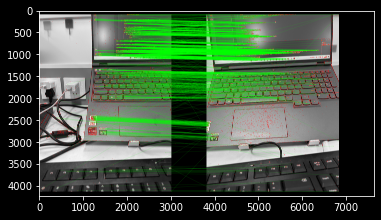

融合时间： 40.29571485519409


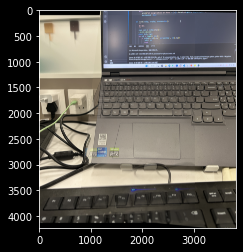

In [8]:
# 输入需要拼接的图片路径
path1 = './1.jpg'
path2 = './2.jpg'

srcImg, warpImg = stitch(path1, path2)
start = time.time()
res = fusion(srcImg, warpImg, '1and2.jpg')
end = time.time()
print('融合时间：', end - start)
# 展示拼接后图片的效果
plt.figure()
plt.imshow(res)
plt.show()
